In [1]:
import cudf
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

num_subsamples = 100
k = 100
hier_idx = 4
layers = ['layer_0_Input', 'layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear']
layer = layers[1]
mov_avg = 10 
save_fig = True
collapse_subsamples = True # whether to average across num_subsamples! currently both computed
p_array = [5, 50, 95]


In [2]:
knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'

SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

if not os.path.exists(PLOTDIR):
    os.makedirs(PLOTDIR)

In [3]:
# helper functions
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

D = data['D']
I = data['I']
I_stand = I/np.max(I)
epochs = data['epochs']

D_k_mean = np.mean(D,axis=1)
D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

In [5]:
# analyses of fixed points and percentiles
# compute percentiles
p = np.percentile(I, p_array, axis=1)
p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
time_diag = np.arange(len(D_k_mean))
time_diag_collapsed = np.arange(len(D_k_mean_collapsed))*100

norms = np.zeros((k-1, I.shape[0]))
for i in range(1, k):
    norms[i-1, :] = I[:, 0] - I[:, i] 

mean_norms = np.mean(norms,axis=0)
mean_k_norms = np.mean(norms,axis=1)
# norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

# norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
fixed_point = np.argmin((norms_mov_avg))
fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))

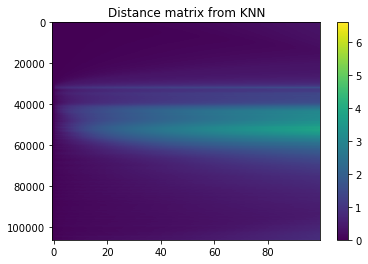

In [6]:
plt.imshow(D,aspect='auto',interpolation=None)
plt.title('Distance matrix from KNN')
plt.colorbar()

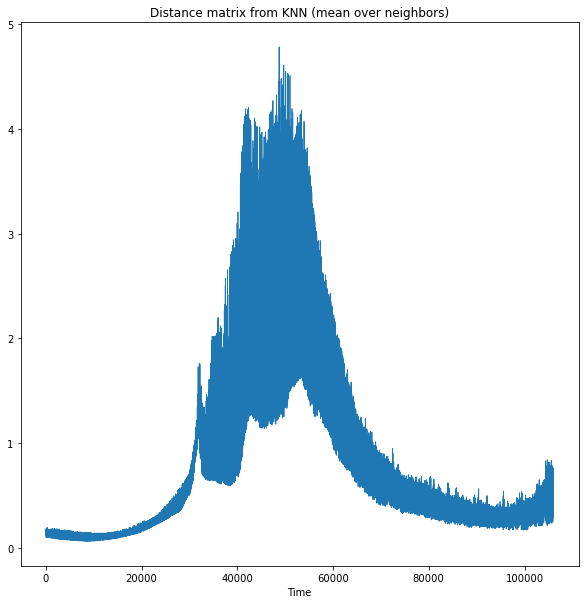

In [89]:
# for exploratory purposes...
plt.figure(figsize=(10,10))
plt.plot(D_k_mean, linewidth=0.8)
plt.title('Distance matrix from KNN (mean over neighbors)')
plt.xlabel('Time')
# plt.xticks(time_diag[0::100], [str(int(element/100)) for element in time_diag[0::100]])
if save_fig:
    plt.savefig(os.path.join(PLOTDIR, f'dist-matrix_time-avg.pdf'), dpi=240)

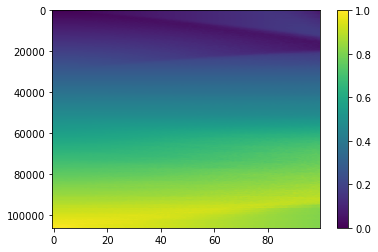

In [90]:
plt.imshow(I_stand,aspect='auto',interpolation=None)
plt.colorbar()

In [91]:
time_diag_collapsed

array([     0,    100,    200, ..., 105700, 105800, 105900])

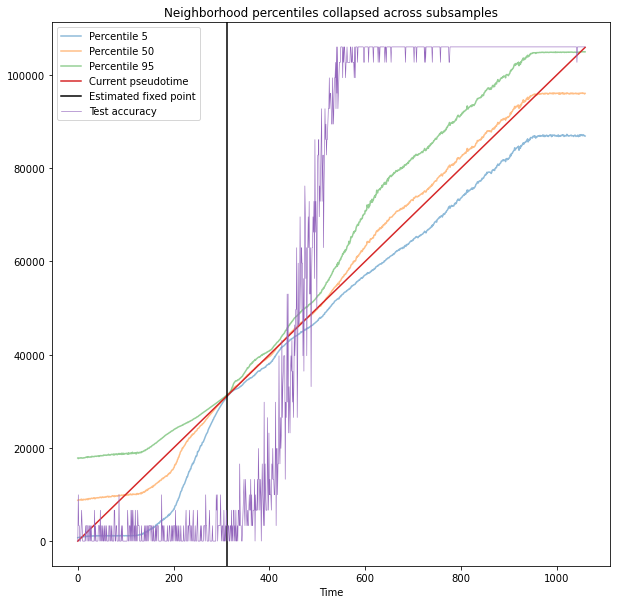

In [92]:
alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p_collapse[0], label=f'Percentile {p_array[0]}', alpha=alpha)
plt.plot(p_collapse[1], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p_collapse[2], label=f'Percentile {p_array[2]}', alpha=alpha)
plt.xlabel('Time')
plt.title('Neighborhood percentiles collapsed across subsamples')
plt.plot(np.arange(len(p_collapse[0])), time_diag_collapsed, label='Current pseudotime')
plt.axvline(x=fixed_point_collapsed, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,1) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

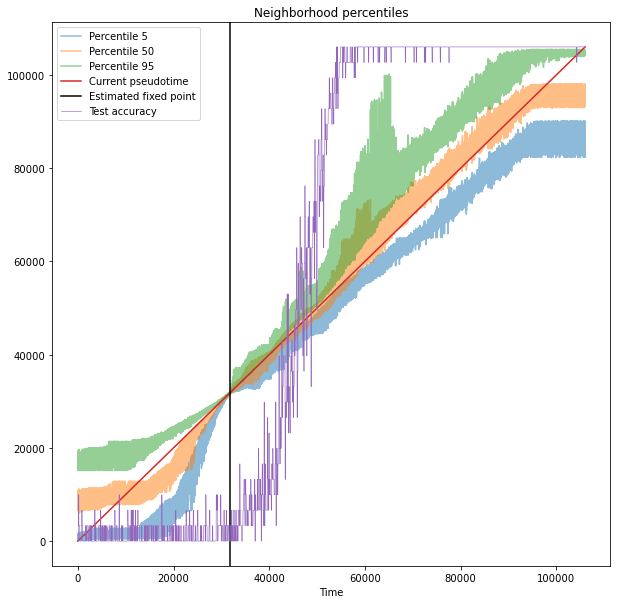

In [93]:
alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p[0,:], label=f'Percentile {p_array[0]}', alpha=alpha)
plt.plot(p[1,:], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p[2,:], label=f'Percentile {p_array[2]}', alpha=alpha)
plt.xlabel('Time')
plt.title('Neighborhood percentiles')
plt.plot(time_diag, label='Current pseudotime')
plt.axvline(x=fixed_point, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

Text(0, 0.5, 'Neighborhood distance')

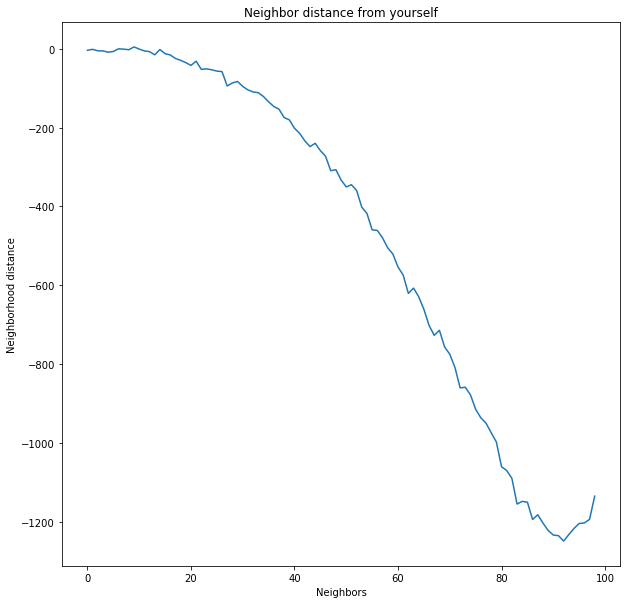

In [94]:
plt.figure(figsize=(10,10))
plt.plot(mean_k_norms)
plt.title('Neighbor distance from yourself')
plt.xlabel('Neighbors')
plt.ylabel('Neighborhood distance')

In [95]:
# this means that the FIRST neighbors, for every point, are most similar to ones backward in time, while other neighbors
# are more forward-looking